### Tutorial in hamiltorch for log probabilities

* For the corresponding blog post please see: https://adamcobb.github.io/journal/hamiltorch.html
* Bayesian neural networks are left to a different notebook 

In [1]:
import torch
import hamiltorch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
hamiltorch.set_random_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Sampling a multivariate Gaussian

In `hamiltorch`, we have designed the samplers to receive a function handle `log_prob_func`, which the sampler will use to evaluate the log probability of each sample. A `log_prob_func` must take a 1-d vector of length equal to the number of parameters that are being sampled. For the example of our multivariate Gaussian distribution, we can define our `log_prob_func` as follows:

In [3]:
def log_prob(omega):
    mean = torch.tensor([1.,2.,3.])
    stddev = torch.tensor([.5,.5,.5])
    return torch.distributions.Normal(mean, stddev).log_prob(omega).sum()

In [4]:
N = 400
step_size = .3
L = 5

### Note Explicit is slower here because Implicit Converges After 2 iterations
* not on GPU as GPU slower

In [5]:
# HMC
hamiltorch.set_random_seed(123)
params_init = torch.zeros(3)
params_hmc = hamiltorch.sample(log_prob_func=log_prob, params_init=params_init, num_samples=N,step_size=step_size,num_steps_per_sample=L)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 400/400 | 485.98       
Acceptance Rate 1.00


In [6]:
# Implicit RMHMC
hamiltorch.set_random_seed(123)
params_init = torch.zeros(3)
params_irmhmc = hamiltorch.sample(log_prob_func=log_prob, params_init=params_init, num_samples=N,step_size=step_size,num_steps_per_sample=L, sampler=hamiltorch.Sampler.RMHMC, integrator=hamiltorch.Integrator.IMPLICIT)

Sampling (Sampler.RMHMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:35 | 0d:00:00:00 | #################### | 400/400 | 11.22       
Acceptance Rate 1.00


In [7]:
# Explicit RMHMC
hamiltorch.set_random_seed(123)
params_init = torch.zeros(3)
omega = 10.
params_ermhmc = hamiltorch.sample(log_prob_func=log_prob, params_init=params_init, num_samples=N,step_size=step_size,num_steps_per_sample=L, sampler=hamiltorch.Sampler.RMHMC, integrator=hamiltorch.Integrator.EXPLICIT, explicit_binding_const=omega)

Sampling (Sampler.RMHMC; Integrator.EXPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:45 | 0d:00:00:00 | #################### | 400/400 | 8.72        
Acceptance Rate 1.00


In [8]:
coords_hmc = torch.cat(params_hmc).reshape(len(params_hmc),-1).numpy()
coords_i_rmhmc = torch.cat(params_irmhmc).reshape(len(params_irmhmc),-1).numpy()
coords_e_rmhmc = torch.cat(params_ermhmc).reshape(len(params_ermhmc),-1).numpy()

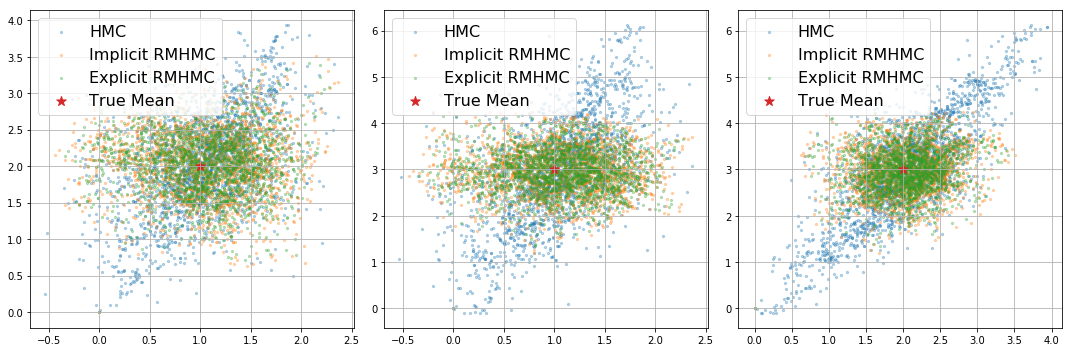

In [9]:
xlim = [0,5]
ylim = [0,5]
fs=16
mean = torch.tensor([1.,2.,3.])
stddev = torch.tensor([.5,.5,.5])

fig, axs = plt.subplots(1, 3, figsize=(15,5))

axs[0].scatter(coords_hmc[:,0], coords_hmc[:,1],s=5,alpha=0.3,label='HMC')
axs[0].scatter(coords_i_rmhmc[:,0], coords_i_rmhmc[:,1],s=5,alpha=0.3,label='Implicit RMHMC')
axs[0].scatter(coords_e_rmhmc[:,0], coords_e_rmhmc[:,1],s=5,alpha=0.3,label='Explicit RMHMC')
axs[0].scatter(mean[0],mean[1],marker = '*',color='C3',s=100,label='True Mean')
axs[0].legend(fontsize=fs)
axs[0].grid()

axs[1].scatter(coords_hmc[:,0], coords_hmc[:,2],s=5,alpha=0.3,label='HMC')
axs[1].scatter(coords_i_rmhmc[:,0], coords_i_rmhmc[:,2],s=5,alpha=0.3,label='Implicit RMHMC')
axs[1].scatter(coords_e_rmhmc[:,0], coords_e_rmhmc[:,2],s=5,alpha=0.3,label='Explicit RMHMC')
axs[1].scatter(mean[0],mean[2],marker = '*',color='C3',s=100,label='True Mean')
axs[1].legend(fontsize=fs)
axs[1].grid()

axs[2].scatter(coords_hmc[:,1], coords_hmc[:,2],s=5,alpha=0.3,label='HMC')
axs[2].scatter(coords_i_rmhmc[:,1], coords_i_rmhmc[:,2],s=5,alpha=0.3,label='Implicit RMHMC')
axs[2].scatter(coords_e_rmhmc[:,1], coords_e_rmhmc[:,2],s=5,alpha=0.3,label='Explicit RMHMC')
axs[2].scatter(mean[1],mean[2],marker = '*',color='C3',s=100,label='True Mean')
axs[2].legend(fontsize=fs)
axs[2].grid()

plt.tight_layout()

# plt.savefig('../../Gaussian_plots.png',bbox_inches='tight')
plt.show()

### KL divergence:

In [10]:
p = torch.distributions.MultivariateNormal(mean, stddev.diag()**2)
q_hmc = torch.distributions.MultivariateNormal(torch.FloatTensor(coords_hmc.mean(0)),torch.diag(torch.FloatTensor(coords_hmc.var(0))))
q_i_rmhmc = torch.distributions.MultivariateNormal(torch.FloatTensor(coords_i_rmhmc.mean(0)),torch.diag(torch.FloatTensor(coords_i_rmhmc.var(0))))
q_e_rmhmc = torch.distributions.MultivariateNormal(torch.FloatTensor(coords_e_rmhmc.mean(0)),torch.diag(torch.FloatTensor(coords_e_rmhmc.var(0))))

print('HMC kl:            ',torch.distributions.kl.kl_divergence(p, q_hmc))
print('Implicit RMHMC kl: ',torch.distributions.kl.kl_divergence(p, q_i_rmhmc))
print('Explicit RMHMC kl: ',torch.distributions.kl.kl_divergence(p, q_e_rmhmc))

HMC kl:             tensor(0.4834)
Implicit RMHMC kl:  tensor(0.0168)
Explicit RMHMC kl:  tensor(0.0423)


In [10]:

p = torch.distributions.MultivariateNormal(mean, stddev.diag()**2)
q_hmc = torch.distributions.MultivariateNormal(torch.FloatTensor(coords_hmc.mean(0)),torch.diag(torch.FloatTensor(coords_hmc.var(0))))
q_i_rmhmc = torch.distributions.MultivariateNormal(torch.FloatTensor(coords_i_rmhmc.mean(0)),torch.diag(torch.FloatTensor(coords_i_rmhmc.var(0))))
q_e_rmhmc = torch.distributions.MultivariateNormal(torch.FloatTensor(coords_e_rmhmc.mean(0)),torch.diag(torch.FloatTensor(coords_e_rmhmc.var(0))))

print('HMC kl:            ',torch.distributions.kl.kl_divergence(p, q_hmc))
print('Implicit RMHMC kl: ',torch.distributions.kl.kl_divergence(p, q_i_rmhmc))
print('Explicit RMHMC kl: ',torch.distributions.kl.kl_divergence(p, q_e_rmhmc))

HMC kl:             tensor(0.4877)
Implicit RMHMC kl:  tensor(0.0160)
Explicit RMHMC kl:  tensor(0.0361)


In [11]:
log_p_hmc = []
for h in params_hmc:
    log_p_hmc.append(log_prob(h))
log_p_irmhmc = []
for h in params_irmhmc:
    log_p_irmhmc.append(log_prob(h))
log_p_ermhmc = []
for h in params_ermhmc:
    log_p_ermhmc.append(log_prob(h))

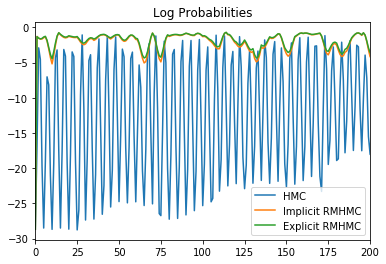

In [12]:
plt.figure()
plt.title('Log Probabilities')
plt.plot(log_p_hmc,label='HMC')
plt.plot(log_p_irmhmc, label='Implicit RMHMC')
plt.plot(log_p_ermhmc,label='Explicit RMHMC')
plt.legend()
plt.xlim([0,200])
plt.show()

# Sampling from a more complicated distribution: funnel distribution

In [13]:
D = 10
eps = 0.

def funnel(dim=D):
    v_dist = torch.distributions.Normal(0,3)
    v = v_dist.sample().view(-1,1)
    x_dist = torch.distributions.Normal(0,torch.exp(-v)**0.5 + eps)
    x = x_dist.sample(sample_shape=(dim,)).view(-1,1)
    w = torch.cat((v,x),0)
    return w.reshape((-1,1))

def funnel_ll(w, dim=D):
    v_dist = torch.distributions.Normal(0,3)
    ll = v_dist.log_prob(w[0])
    x_dist = torch.distributions.Normal(0,torch.exp(-w[0])**0.5  + eps)
    ll += x_dist.log_prob(w[1:]).sum()
    return ll

In [14]:
# HMC
hamiltorch.set_random_seed(123)
params_init = torch.ones(D + 1)
params_init[0] = 0.
step_size = 0.3093
num_samples = 500
L = 25#10
omega=100
threshold = 1e-3
softabs_const=10**6

params_hmc = hamiltorch.sample(log_prob_func=funnel_ll, params_init=params_init, num_samples=num_samples,
                               step_size=step_size, num_steps_per_sample=L)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:11 | 0d:00:00:00 | #################### | 500/500 | 42.49       
Acceptance Rate 0.99


In [15]:
# Implicit RMHMC with SOFTABS
hamiltorch.set_random_seed(123)
params_init = torch.ones(D + 1)
params_init[0] = 0.
step_size = 0.15
num_samples = 100
L = 25
threshold = 1e-3
softabs_const=10**6

params_i_rmhmc = hamiltorch.sample(log_prob_func=funnel_ll, params_init=params_init, num_samples=num_samples,
                                   sampler=hamiltorch.Sampler.RMHMC, integrator=hamiltorch.Integrator.IMPLICIT,
                                   metric=hamiltorch.Metric.SOFTABS, fixed_point_threshold=threshold, jitter=0.01,
                                   num_steps_per_sample=L, step_size=step_size, softabs_const=softabs_const)

Sampling (Sampler.RMHMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Invalid log_prob: -inf, params: tensor([ -138.4124, -3658.8066,  -274.0623, -1623.2284,  -239.4869,  -424.7377,
        -2083.7095,   535.0222,  -755.3480,    76.5668,   363.7591],
       grad_fn=<AddBackward0>)
Invalid hamiltonian, log_prob: -39.69970703125, params: tensor([ -4.9909,   2.4258,  -1.6827,  -8.6858,   6.2626,  12.6014, -10.4627,
          7.2629, -11.4338,  -7.1488,   2.7413], requires_grad=True), momentum: tensor([ 1.1495e+22,  2.1765e+19, -9.9075e+19, -2.7240e+20,  1.0491e+20,
         3.2692e+20, -2.8741e+20,  4.4697e+20, -2.6421e+20, -2.2609e+20,
         2.2216e+19])
Invalid log_prob: -inf, params: tensor([ -108.6884,  -334.2923,   895.0775,  -347.5304,  -339.9717,  -390.7962,
         -827.4655,  2223.1108,  -364.0344, -1833.2838,   555.0710],
       grad_fn=<AddBackward0>)
Invalid hamiltonian, log_prob: -40.49718475341797, params: tensor([-4.9723,

In [16]:
# Explicit RMHMC with SOFTABS
hamiltorch.set_random_seed(123)
params_init = torch.ones(D + 1)
params_init[0] = 0.
step_size = 0.15
num_samples = 100
L = 25
omega=10
softabs_const=10**6

params_e_rmhmc = hamiltorch.sample(log_prob_func=funnel_ll, params_init=params_init, num_samples=num_samples,
                                   sampler=hamiltorch.Sampler.RMHMC, integrator=hamiltorch.Integrator.EXPLICIT,
                                   metric=hamiltorch.Metric.SOFTABS, fixed_point_threshold=threshold, jitter=0.01,
                                   num_steps_per_sample=L, step_size=step_size, explicit_binding_const=omega, 
                                   softabs_const=softabs_const)

Sampling (Sampler.RMHMC; Integrator.EXPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Invalid hessian: tensor([[nan, -inf, inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [-inf, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [inf, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [-inf, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [-inf, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [-inf, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [-inf, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [-inf, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [-inf, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [-inf, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [-inf, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<DivBackward0>), params: tensor([  75.5394,  -10.3087,    8.2127,  -20.3933,  -65.2353,  -19.7363,
         -21.455

In [17]:
coords_hmc = torch.cat(params_hmc).reshape(len(params_hmc),-1).numpy()
coords_i_rmhmc = torch.cat(params_i_rmhmc).reshape(len(params_i_rmhmc),-1).numpy()
coords_e_rmhmc = torch.cat(params_e_rmhmc).reshape(len(params_e_rmhmc),-1).numpy()

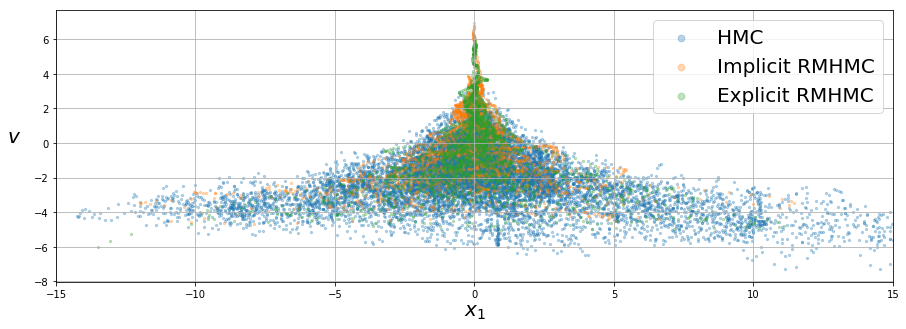

In [18]:
plt.figure(figsize=(15,5))
plt.scatter(coords_hmc[:,1], coords_hmc[:,0],s=5,alpha=0.3,label='HMC')
plt.scatter(coords_i_rmhmc[:,1], coords_i_rmhmc[:,0],s=5,alpha=0.3,label='Implicit RMHMC')
plt.scatter(coords_e_rmhmc[:,1], coords_e_rmhmc[:,0],s=5,alpha=0.3,label='Explicit RMHMC')
plt.legend(fontsize=20,markerscale=3)
plt.xlim([-15,15])
plt.xlabel('$x_1$',fontsize=20)
plt.ylabel('$v$',fontsize=20, rotation=0,labelpad=20)
plt.grid()
# plt.savefig('../../funnel_samples.png',bbox_inches='tight')
plt.show()

We can also plot the marginal distributions of $v$ by representing them in histograms. We plot the known Gaussian distribution in each figure for comparison. The KL divergence is also included to measure how close the empirical distribution is from the true one.

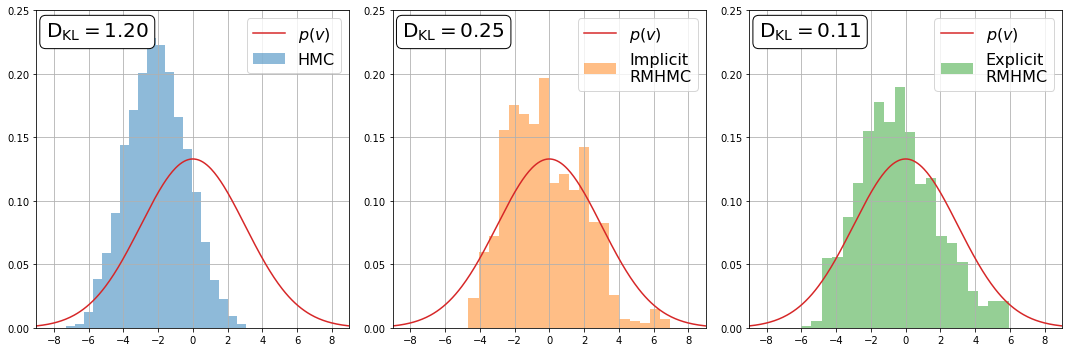

In [19]:
xlim = [-9,9]
ylim = [0,.25]
text_x = -5.5
text_y = .233
font_size_text = 20
vxx = torch.linspace(xlim[0],xlim[1],300)
p = torch.distributions.Normal(0,3)
v_pdf = torch.exp(p.log_prob(vxx))

fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].hist(coords_hmc[:,0], color='C0', bins=20,density=True, alpha=0.5, label='HMC')
axs[0].plot(vxx.numpy(), v_pdf.numpy(),'C3',label='$p(v)$')
axs[0].legend(loc=0,fontsize=fs)
axs[0].grid()
axs[0].set_xlim(xlim)
axs[0].text(text_x, text_y, "$\mathrm{D_{KL}} = 1.20$", size=font_size_text, rotation=0.,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec="k", # Outer colour
                   fc='w',
                   )
         )
axs[0].set_ylim(ylim)

axs[1].hist(coords_i_rmhmc[:,0], color='C1',bins=20,density=True, alpha=0.5,label='Implicit\nRMHMC')
axs[1].plot(vxx.numpy(), v_pdf.numpy(),'C3', label='$p(v)$')
axs[1].legend(loc=0,fontsize=fs)
axs[1].grid()
axs[1].set_xlim(xlim)
axs[1].text(text_x, text_y, "$\mathrm{D_{KL}} = 0.25$", size=font_size_text, rotation=0.,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec="k", # Outer colour
                   fc='w',
                   )
         )
axs[1].set_ylim(ylim)
axs[2].hist(coords_e_rmhmc[:,0], color='C2',bins=20,density=True, alpha=0.5, label='Explicit\nRMHMC')
axs[2].plot(vxx.numpy(), v_pdf.numpy(),'C3',label='$p(v)$')
axs[2].legend(loc=0,fontsize=fs)
axs[2].grid()
axs[2].set_xlim(xlim)
axs[2].text(text_x, text_y, "$\mathrm{D_{KL}} = 0.11$", size=font_size_text, rotation=0.,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec="k", # Outer colour
                   fc='w',
                   )
         )
axs[2].set_ylim(ylim)

plt.tight_layout()

# plt.savefig('../../funnel_hist_plots.png',bbox_inches='tight')
plt.show()

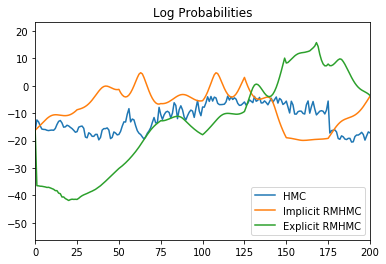

In [20]:
log_p_hmc = []
for h in params_hmc:
    log_p_hmc.append(funnel_ll(h))
log_p_irmhmc = []
for h in params_i_rmhmc:
    log_p_irmhmc.append(funnel_ll(h))
log_p_ermhmc = []
for h in params_e_rmhmc:
    log_p_ermhmc.append(funnel_ll(h))
plt.figure()
plt.title('Log Probabilities')
plt.plot(log_p_hmc,label='HMC')
plt.plot(log_p_irmhmc, label='Implicit RMHMC')
plt.plot(log_p_ermhmc,label='Explicit RMHMC')
plt.legend()
plt.xlim([0,200])
plt.show()

In [21]:
p = torch.distributions.Normal(0,3)
q_hmc = torch.distributions.Normal(coords_hmc[:,0].mean(),coords_hmc[:,0].std())
q_i_rmhmc = torch.distributions.Normal(coords_i_rmhmc[:,0].mean(),coords_i_rmhmc[:,0].std())
q_e_rmhmc = torch.distributions.Normal(coords_e_rmhmc[:,0].mean(),coords_e_rmhmc[:,0].std())

print('HMC kl:            ',torch.distributions.kl.kl_divergence(p, q_hmc))
print('Implicit RMHMC kl: ',torch.distributions.kl.kl_divergence(p, q_i_rmhmc))
print('Explicit RMHMC kl: ',torch.distributions.kl.kl_divergence(p, q_e_rmhmc))

HMC kl:             tensor(1.2109)
Implicit RMHMC kl:  tensor(0.1397)
Explicit RMHMC kl:  tensor(0.1118)


###  Before edits to code:

In [24]:
p = torch.distributions.Normal(0,3)
q_hmc = torch.distributions.Normal(coords_hmc[:,0].mean(),coords_hmc[:,0].std())
q_i_rmhmc = torch.distributions.Normal(coords_i_rmhmc[:,0].mean(),coords_i_rmhmc[:,0].std())
q_e_rmhmc = torch.distributions.Normal(coords_e_rmhmc[:,0].mean(),coords_e_rmhmc[:,0].std())

print('HMC kl:            ',torch.distributions.kl.kl_divergence(p, q_hmc))
print('Implicit RMHMC kl: ',torch.distributions.kl.kl_divergence(p, q_i_rmhmc))
print('Explicit RMHMC kl: ',torch.distributions.kl.kl_divergence(p, q_e_rmhmc))

HMC kl:             tensor(1.1998)
Implicit RMHMC kl:  tensor(0.1796)
Explicit RMHMC kl:  tensor(0.1136)


In [25]:
2**0.5

1.4142135623730951